In [1]:
import pandas as pd
import json
import requests
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


In [2]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [3]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [4]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [5]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)
    
    def to_dict(self):
        return{
            'distance': self.distance,
            'duration': self.duration
        }


In [6]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [7]:
def osrm_route_request(from_place, to_place):
    url_coords = '{}{},{};{},{}' \
        .format('http://0.0.0.0:5000/route/v1/driving/',
                from_place.get('lon'), from_place.get('lat'), to_place.get('lon'), to_place.get('lat'))
    url_full = url_coords + '?annotations=true&geometries=geojson&steps=true'
    resp = requests.get(url=url_full)
    return _parse_osrm_response(resp)


def _parse_osrm_response(resp):
    # if resp.status_code != requests.codes.ok:
    #     resp.raise_for_status()

    jresp = resp.json()
    # if jresp.get('code') != 'Ok':
    #     log.error(jresp.get('code'))
    #     log.error(jresp.get('message'))
    #     resp.raise_for_status()

    trip = Trip()
    trip.legs = [Leg()]
    trip.legs[0].steps = []

    legs = jresp.get('routes')[0].get('legs')
    for leg in legs:
        steps = leg.get('steps')
        for step in steps:
            new_step = Step(distance=step.get('distance'),
                            duration=step.get('duration'),
                            start_coord=Coord(lon=step.get('geometry').get('coordinates')[0][0],
                                              lat=step.get('geometry').get('coordinates')[0][1]),
                            end_coord=Coord(lon=step.get('geometry').get('coordinates')[-1][0],
                                            lat=step.get('geometry').get('coordinates')[-1][1]))
            # OSRM makes circles on roundabouts. And makes empty step in the end. Exclude these cases from a route
            if new_step.start_coord != new_step.end_coord:
                trip.legs[0].steps.append(new_step)
        if len(trip.legs[0].steps) == 0:
            waypoints = jresp.get('waypoints')
            trip.legs[0].steps.append(Step(distance=0,
                                           duration=0,
                                           start_coord=Coord(lon=waypoints[0].get('location')[0],
                                                             lat=waypoints[0].get('location')[1]),
                                           end_coord=Coord(lon=waypoints[1].get('location')[0],
                                                           lat=waypoints[1].get('location')[1])
                                           )
                                      )
    trip.legs[0].start_coord = trip.legs[0].steps[0].start_coord
    trip.legs[0].end_coord = trip.legs[0].steps[-1].end_coord
    trip.legs[0].duration = sum([step.duration for step in trip.legs[0].steps])
    trip.legs[0].distance = sum([step.distance for step in trip.legs[0].steps])
    trip.legs[0].mode = OtpMode.DRT

    trip.distance = trip.legs[0].distance
    trip.duration = trip.legs[0].duration
    trip.main_mode = OtpMode.CAR
    return trip


In [15]:
persons = json.load(open('data/population_sjobo_others.json'))

In [16]:
# sample = random.sample(persons['persons'], int(len(persons['persons'])/100))
sample = persons['persons']

In [17]:
len(sample)

3311053

In [18]:
persons['persons'][0]

{'activities': [{'coord': {'lat': 56.15307599069771,
    'lon': 12.577639938001655},
   'end_time': '37560',
   'start_time': 0,
   'type': '5',
   'zone': 1284},
  {'coord': {'lat': 56.1435, 'lon': 12.68309145},
   'end_time': 86400,
   'start_time': '37560',
   'type': '4',
   'zone': 1283}],
 'attributes': {'age': 'Ald7_15'},
 'id': 0}

In [17]:
trip_lengths = [osrm_route_request(person['activities'][0]['coord'], person['activities'][1]['coord']) for person in sample]

In [18]:
pd.DataFrame.from_records([t.to_dict() for t in trip_lengths]).to_feather('data/sjöbo_trips_analysis.feather')

In [19]:
pd.read_feather('data/sjöbo_trips_analysis.feather')

,distance,duration
0,6333.0,745.4
1,6406.5,760.5
2,1585.5,263.3
3,2507.8,265.5
4,2195.1,241.9
...,...,...
33235,3461.7,379.7
33236,3206.9,330.0
33237,349.3,52.7
33238,6864.3,564.5


In [20]:
pd.DataFrame.from_records([(s['attributes']['age'], s['activities'][1]['type']) for s in sample], columns=['age', 'type']).to_feather('data/sample-age-type.feather')

# and the results

In [21]:
sample_result = pd.concat([pd.read_feather('data/sample-age-type.feather'), pd.read_feather('data/sjöbo_trips_analysis.feather')], axis=1)

In [22]:
sample_result['type'] = sample_result.type.astype(int)
sample_result['distance'] = sample_result.distance / 1000

In [23]:
sample_result

,age,type,distance,duration
0,Ald45_64,6,6.3330,745.4
1,Ald45_64,1,6.4065,760.5
2,Ald7_15,4,1.5855,263.3
3,Ald7_15,7,2.5078,265.5
4,Ald7_15,1,2.1951,241.9
...,...,...,...,...
33235,Ald25_44,14,3.4617,379.7
33236,Ald25_44,14,3.2069,330.0
33237,Ald25_44,1,0.3493,52.7
33238,Ald20_24,4,6.8643,564.5


array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

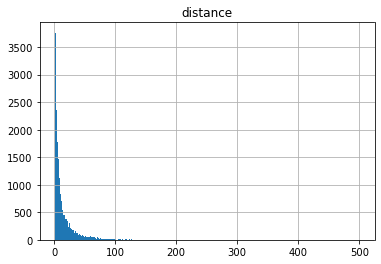

In [24]:
distance = np.linspace(1, 500, 500)

sample_result.hist(column=['distance'], bins=distance)

In [25]:
len(sample_result.index)

33240

/tmp/ipykernel_16977/3387709699.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['distance'][:, np.newaxis])
/tmp/ipykernel_16977/3387709699.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['distance'][:, np.newaxis])
/tmp/ipykernel_16977/3387709699.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['distance'][:, np.newaxis])
/tmp/ipykernel_16977/3387709699.py:10: FutureWarning: Support for mult

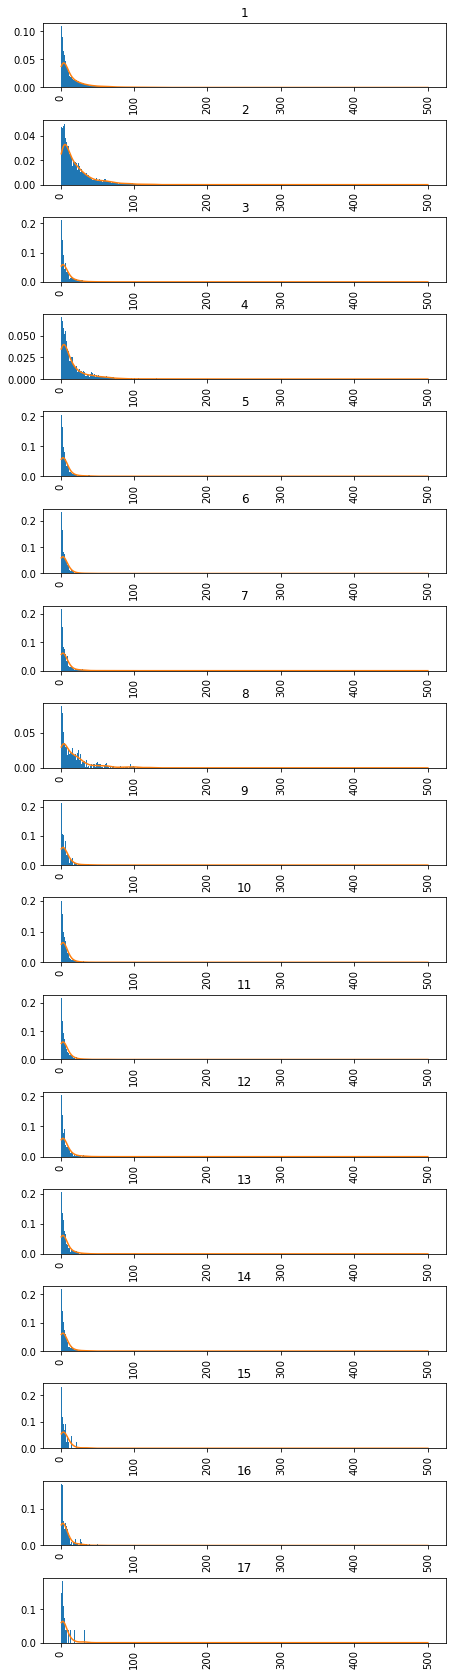

In [26]:
distance = np.linspace(1, 500, 500)

fig, ax = plt.subplots(nrows=17, figsize=(7,30))
sample_result.hist(column=['distance'], by=['type'],bins=distance, density=True, ax=ax)

for axi, ind in zip(ax.flat, range(1,18)):
    df = sample_result[['distance', 'type']][sample_result['type']==ind]
    if len(df.index) == 0:
        continue
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['distance'][:, np.newaxis])
    log_dens = kde.score_samples(distance[:, np.newaxis])
    probability = np.exp(log_dens)

    axi.plot(distance, probability)

In [21]:
sample_result.type.value_counts(normalize='True')

1     0.385651
2     0.169001
4     0.080667
6     0.053752
5     0.048744
10    0.040294
3     0.035756
13    0.035521
7     0.035443
11    0.027463
14    0.024411
12    0.022925
8     0.019873
9     0.009154
16    0.007981
15    0.001956
17    0.001408
Name: type, dtype: float64

In [22]:
sample_result.type.value_counts()

1     4929
2     2160
4     1031
6      687
5      623
10     515
3      457
13     454
7      453
11     351
14     312
12     293
8      254
9      117
16     102
15      25
17      18
Name: type, dtype: int64

# Commuters to and from Sjöbo

In [97]:
df = {}
for person in persons['persons']:
    if person['activities'][1]['type'] != '2':
        continue
        
    szone = person['activities'][0]['zone']
    ezone = person['activities'][1]['zone']
    if szone not in df.keys():
        df[szone] = {}
    
    if ezone not in df[szone].keys():
        df[szone][ezone] = 1
    else:
        df[szone][ezone] += 1

In [98]:
od = pd.DataFrame.from_dict(df)

In [99]:
od = od.replace(np.NAN, 0)

In [100]:
od[1265]

1283      50
1284       8
1278       2
1230      54
1214      29
1282      32
1381       9
1292      14
1261      47
1280     154
1277      13
1276      18
1265    3715
1281     843
1285     183
1293      74
1257       5
1260       4
1233      40
1290     200
1262      50
1267      58
765        2
1275       2
1380       4
767        3
1287      47
1256      16
1264     240
1083       6
1231      21
1291     200
1266     379
1270     551
1263      39
763        1
1082       2
780        1
1273       8
1060       3
1272       3
1286     278
781        2
764        1
Name: 1265, dtype: int64

In [101]:
from1265 = pd.read_excel('data/Commuters from 1265.xlsx', header=None)
from1265['to'] = from1265[1].apply(lambda x: x.split(' ')[0])
from1265 = from1265.drop([0,1], axis=1)
from1265.columns = ['trips', 'to']
from1265 = from1265.set_index('to')

In [102]:
to1265 = pd.read_excel('data/Commuters to 1265.xlsx', header=None)
to1265['from'] = to1265[0].apply(lambda x: x.split(' ')[0])
to1265 = to1265.drop([0,1,2], axis=1)
to1265.columns = ['trips', 'from']
to1265 = to1265.set_index('from')

In [103]:
trips = from1265 + to1265

In [104]:
trips.index = trips.index.astype(int)

In [105]:
trips.loc[1265] = trips.loc[1265]/2

In [106]:
scb_trips = trips

In [107]:
od_trips = (od[1265] + od.loc[1265])/2

In [109]:
diff = pd.concat([scb_trips,od_trips], axis=1).dropna()

In [112]:
diff['diff'] = diff['trips'] - diff[1265]

In [114]:
diff['ratio'] = diff['trips'] / diff[1265]

In [115]:
diff.describe()

,trips,1265,diff,ratio
count,44.000000,44.000000,44.000000,44.000000
mean,260.840909,189.454545,71.386364,1.865398
std,724.820072,579.997262,192.111700,3.599139
min,0.000000,0.500000,-46.000000,0.000000
25%,3.000000,4.250000,-5.625000,0.647097
50%,17.500000,20.000000,0.750000,1.183715
75%,129.000000,82.000000,35.625000,1.660097
max,4337.000000,3715.000000,706.500000,24.000000


In [118]:
diff[diff['trips'] > 50]

,trips,1265,diff,ratio
1230,213,95.5,117.5,2.230366
1231,128,48.5,79.5,2.639175
1261,61,63.0,-2.0,0.968254
1263,127,68.0,59.0,1.867647
1264,291,226.0,65.0,1.287611
1265,4337,3715.0,622.0,1.167429
1266,311,347.5,-36.5,0.894964
1267,91,57.0,34.0,1.596491
1270,660,471.5,188.5,1.399788
1280,1440,839.5,600.5,1.715307
